# Binary Performance Evaluator – Demo Completo

Neste exemplo vamos treinar um classificador simples e explorar várias funcionalidades do `BinaryPerformanceEvaluator`. Usaremos dados sintéticos.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from riskpilot.evaluation import BinaryPerformanceEvaluator
from riskpilot.synthetic import LookAhead

from sklearn.utils.class_weight import compute_sample_weight

In [2]:
# --------------------------------------------------
# 1. CONFIGURAÇÕES
# --------------------------------------------------
FILE_PATH = "../../datasets/lending_club/accepted_2007_to_2018Q4.csv"
NROWS     = 10_000
TARGET_RAW = "loan_status"          # coluna original
TARGET     = "target"               # nome final binário

# --------------------------------------------------
# 2. LEITURA E CONVERSÃO DE TIPOS MISTOS
# --------------------------------------------------
def read_and_clean_csv_mixed_types(path, nrows=None, verbose=True):
    df = pd.read_csv(path, low_memory=False, nrows=nrows)

    # identificar colunas com tipos mistos
    for col in df.columns:
        types = df[col].dropna().map(type).value_counts()
        if len(types) > 1 and verbose:
            print(f"[!] '{col}' com múltiplos tipos: {dict(types)}")

        # tentativa de conversão automática p/ numérico
        if len(types) > 1:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            except Exception:
                df[col] = df[col].astype(str)

    return df

df = read_and_clean_csv_mixed_types(FILE_PATH, nrows=NROWS)

# drop de colunas não usadas (caso existam)
df.drop(columns=[c for c in ["member_id"] if c in df.columns], inplace=True)

# --------------------------------------------------
# 3. TARGET BINÁRIO
# --------------------------------------------------
bad_status = ["Charged Off", "Default", "Late (31-120 days)"]
df[TARGET] = df[TARGET_RAW].isin(bad_status).astype(int)

# --------------------------------------------------
# 4. DATA E ID
# --------------------------------------------------
#df["date"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")

df["date"] = pd.to_datetime('202201', format="%Y%M", errors="coerce")

df.drop(columns=["issue_d", TARGET_RAW], inplace=True)

df.reset_index(drop=False, inplace=True)   # index ➜ nova coluna

# --------------------------------------------------
# 5. FEATURES NUMÉRICAS + IMPUTAÇÃO
# --------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(["id", TARGET])
na_threshold = 0.30
valid_cols = numeric_cols[df[numeric_cols].isna().mean() < na_threshold].tolist()
valid_cols.remove('index')

df[valid_cols] = df[valid_cols].fillna(df[valid_cols].median())

# --------------------------------------------------
# 6. DATAFRAME FINAL
# --------------------------------------------------

FEATURES = [
    "funded_amnt_inv",
    "annual_inc",
    "dti",
    "fico_range_high",
    "out_prncp_inv",
    "total_rec_prncp",
    "last_pymnt_amnt",
    "last_fico_range_low",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_tl_op_past_12m",
    "percent_bc_gt_75",
    "total_bc_limit",
    #"sub_grade"
]

ID_COLS = ['id']

IGNORE_COLS = ['member_id']

DATE_COLS = ['date']

# --------------------------------------------------
# Preparar dataset base
# --------------------------------------------------
df_model = df[ID_COLS+DATE_COLS+[TARGET] + FEATURES].dropna().copy()

In [3]:
ID_COLS

['id']

In [4]:
# df_model['date'] = pd.to_datetime(df_model['date'], format='%yyyy%mm')
# Cria a coluna yyyymm como inteiro
df_model['date'] = df_model['date'].dt.year * 100 + df_model['date'].dt.month


#df_model['yyyymm_datetime'] = df_model['date'].dt.to_period('M').dt.to_timestamp()
#DATE_COLS = ['date']
DATE_COLS

['date']

In [5]:
import numpy as np
from riskpilot.synthetic import LookAhead

gen = LookAhead(
    id_cols=ID_COLS,
    date_cols=DATE_COLS
).fit(df_model)

In [6]:
print(df_model['date'].min())
print(df_model['date'].max())

202201
202201


In [7]:
synthetic = gen.generate(
    n_periods=36,
    freq='ME',
    scenario='stress')
print(synthetic['date'].min())
print(synthetic['date'].max())

display(synthetic.head())

202202
202501


,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
0,0875e90b0c0e4ca495ced6ab0fad0250,202202,1,8000.000000,45000.000000,27.598985,674.0,0.0,1038.770690,4.727045,...,5446.527779,311.494703,3.0,1.0,3,2.0,5.0,10.0,0.0,11320.193267
1,766a3b27923444ec98e4d1abb7d03624,202202,0,10000.000000,50000.000000,17.213333,694.0,0.0,12304.506323,5574.177172,...,4241.501086,172.000000,2.0,2.0,3,7.0,5.0,4.0,66.7,9462.327536
2,5b7e29043b91481fb770b3dd61cadc76,202202,0,19544.921468,55000.000000,31.248754,669.0,0.0,12210.792506,312.116757,...,1109.361404,460.144272,0.0,0.0,6,1.0,0.0,9.0,66.7,10642.261035
3,b4816aded0104c6ba4c01be24252ac3d,202202,0,20000.000000,60000.000000,10.453876,714.0,0.0,22000.000000,802.795611,...,11492.940417,45.000000,1.0,2.0,4,2.0,5.0,4.0,25.0,11900.000000
4,bb09cc1057db40c9bc4573a27f18269e,202202,0,10000.000000,72366.560038,6.421247,779.0,0.0,10000.000000,2632.597222,...,16057.190769,170.000000,15.0,12.0,2,5.0,5.0,1.0,0.0,15500.905958


In [8]:
custom_noise = {
    'utilifico_range_highzation': {'func': np.random.exponential, 'kwargs': {'scale':50}},
}
custom_gen = LookAhead(
    id_cols=['id'],
    date_cols=['date'],
    custom_noise=custom_noise).fit(df_model)

custom = custom_gen.generate(
    n_periods=2,
    freq='ME',
    scenario='stress'
    )

custom.head()
print(custom['date'].min())
print(custom['date'].max())

display(custom.head())



202202
202203


,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
0,6a05e3078d4f49b6a335a476259c58d1,202202,0,12000.000000,60000.000000,18.449792,679.0,0.0,7899.152671,6177.243854,...,3980.137705,40.000000,9.000000,6.000000,3,28.000000,5.0,2.0,16.700000,17600.000000
1,16733a428bf64ad08018d8105926ee4c,202202,0,8000.000000,55000.000000,13.088291,729.0,0.0,8000.000000,577.629893,...,422.658239,125.000000,98.118765,40.596234,1,135.934057,17.0,0.0,87.918451,5238.595884
2,fb02e2612af04588aee63b9161d3ef81,202202,0,16641.756752,85000.000000,29.896834,714.0,0.0,20000.000000,8114.879731,...,3155.662716,344.851129,20.000000,18.000000,5,33.000000,5.0,1.0,58.264002,48030.328477
3,8627508c538441ab93bd6a7469cdaaff,202202,0,26575.735881,495489.669032,12.283010,669.0,0.0,20000.000000,1693.433097,...,187.024427,183.000000,31.000000,40.421463,1,108.267246,5.0,0.0,100.000000,21904.381979
4,e5267ddb413e49129703ece692b2adbd,202202,0,9000.000000,45000.000000,23.897847,724.0,0.0,10397.976909,517.297027,...,1750.000603,127.000000,13.000000,3.000000,0,208.153284,0.0,2.0,33.300000,8568.887496


In [9]:
len1=len(df_model)
print(df_model.shape)

df_model = pd.concat([df_model, synthetic], axis=0)

len2=len(df_model)
print(df_model.shape)

assert len2-len1==len(synthetic)

(10000, 23)
(46500, 23)


In [10]:
# --------------------------------------------------
# 2. Split treino / teste
# --------------------------------------------------
train_idx, test_idx = train_test_split(
    df_model.index,
    test_size=0.30,
    stratify=df_model[TARGET],
    random_state=42,
)

# Criar df_train e df_test primeiro
df_train = df_model.loc[train_idx].copy()
df_test  = df_model.loc[test_idx].copy()

# Depois extrair X e y a partir dos DataFrames
X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test , y_test  = df_test[FEATURES] , df_test[TARGET]


print(X_train.shape)
print(X_test.shape)

(46566, 20)
(19934, 20)


In [11]:
# --------------------------------------------------
# Garantir cópias independentes dos conjuntos de treino e teste
# --------------------------------------------------
X_train = df_train[FEATURES].copy()
X_test = df_test[FEATURES].copy()

# --------------------------------------------------
# Converter colunas categóricas (tipo object) para 'category' em X e df
# --------------------------------------------------
def convert_object_to_category(df):
    obj_cols = df.select_dtypes(include='object').columns
    df[obj_cols] = df[obj_cols].astype('category')
    return df

# Aplicar nos conjuntos usados no modelo
X_train = convert_object_to_category(X_train)
X_test = convert_object_to_category(X_test)

# Garantir que df_train e df_test também estejam com tipos consistentes
df_train = convert_object_to_category(df_train)
df_test = convert_object_to_category(df_test)

# --------------------------------------------------
# Verificações finais
# --------------------------------------------------
print("Colunas 'object' restantes em X_train:", X_train.dtypes[X_train.dtypes == 'object'])
print("Colunas 'object' restantes em df_test:", df_test.dtypes[df_test.dtypes == 'object'])

print(X_train.shape)
print(X_test.shape)

Colunas 'object' restantes em X_train: Series([], dtype: object)
Colunas 'object' restantes em df_test: Series([], dtype: object)
(46566, 20)
(19934, 20)


In [12]:
num_cols = df_train.select_dtypes(include=[float, int]).columns.tolist()

for col in ['index', 'id', TARGET]:
    try:
        num_cols.remove(col)
    except:
        pass   

In [13]:
df_model[df_model['id']=='cf52877e86264394ab4730041be1fbcb']

,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit


In [14]:
# # Linhas “extras” que existem em evaluator.df_train mas não em y_train (via índice)
# extra_idx = set(evaluator.df_train.index) - set(y_train.index)
# print(f"Linhas extras: {len(extra_idx)}")     # → 3 832 (= 54 615-50 783)
# # Inspecione algumas para ver por que foram descartadas na etapa de modelagem
# evaluator.df_train.loc[list(extra_idx)].head()


In [15]:
# Aplicar o DynamicScaler no treino
from riskpilot.utils.scaler import DynamicScaler
scaler = DynamicScaler(
    strategy="auto",
    shapiro_p_val = 0.01, # se aumentar fica mais restritiva a escolha de StandardScaler()
    #serialize=True,
    #save_path="scalers.pkl", # arquivo com informações de escalonamento salvas 
    random_state=42,
    ignore_cols=ID_COLS+IGNORE_COLS+DATE_COLS+[TARGET]
)

scaler.fit(df_train)

# Relatório das decisões
#print("\nResumo das decisões por feature:")
#display(scaler.report_as_df())

INFO: Ignoring columns (no scaling): ['target', 'date']


DynamicScaler(extra_scalers=[],
              ignore_cols={'id', 'date', 'target', 'member_id'},
              ignore_scalers=set(),
              logger=<Logger riskpilot.utils.scaler (INFO)>, random_state=42,
              save_path=WindowsPath('scalers.pkl'),
              scoring=<function DynamicScaler.__init__.<locals>.<lambda> at 0x000001FA2A559900>)

In [16]:
#display(X_train.head())

# 5. Transformar o conjunto de treino
df_train_scaled = scaler.transform(df_train, return_df=True)
X_train_scaled = scaler.transform(X_train, return_df=True)

print(X_train.shape)
print(X_train_scaled.shape)

# print("\nExemplo de dados escalados (treino):")
# display(X_train_scaled.head())

INFO: Untouched columns preserved: ['id', 'target', 'date']


(46566, 20)
(46566, 20)


In [17]:
#display(X_test.head())

# 5. Transformar o conjunto de treino
df_test_scaled = scaler.transform(df_test, return_df=True)
X_test_scaled = scaler.transform(X_test, return_df=True)

print(X_test.shape)
print(X_test_scaled.shape)


# print("\nExemplo de dados escalados (treino):")
# display(X_test_scaled.head())

INFO: Untouched columns preserved: ['id', 'target', 'date']


(19934, 20)
(19934, 20)


In [18]:
# # Visualizar
# scaler.plot_histograms(
#     df_train,
#     X_train_scaled,
#     features=num_cols)

In [19]:
# encoder = WOEGuard(
#     categorical_cols=categorical_cols,
#     drop_original=True,       # mantém ou remove colunas originais
#     suffix='_woe',            # sufixo para as novas colunas
#     alpha=0.5,                # suavização Laplace
#     default_woe=0.0,          # WoE default para categorias novas
#     include_nan=True          # trata NaN como categoria separada
# )

In [20]:
# # 2. Ajustar e transformar
# df_transformed = encoder.fit_transform(
#     X=df[categorical_cols], # a lista de colunas não precisa ser igual à categorical_cols, mas somente as que forem instanciadas no WOEGuard que serão codificadas.
#     y=df[TARGET]
# )
# display(df_transformed)

In [21]:
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

# # Modelo 1: Regressão Logística
# model1 = LogisticRegression(
#     max_iter=2000,
#     solver='lbfgs',
#     class_weight=None,      # Removido porque vamos usar sample_weight manualmente
#     C=1.0
# )
# model1.fit(X_train, y_train, sample_weight=sample_weights_train)


# Modelo 2: XGBoost


model2 = XGBClassifier(
    n_estimators=150,
    #class_weights='balanced',
    learning_rate=0.05,
    max_depth=5,
    subsample=0.85,
    colsample_bytree=0.80,
    #scale_pos_weight=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    #enable_categorical=True,
    #tree_method='hist'  # necessário com enable_categorical=True
)
model2.fit(
    X_train,
    y_train,
    sample_weight=sample_weights_train
    );

In [22]:
# gambiarra rapida
#df_train = pd.concat([X_train_scaled, y_train], axis=1)
#df_test = pd.concat([X_test_scaled, y_train], axis=1)

In [23]:
#df_train.shape

df_train['date'].min(),df_train['date'].max()

(202201, 202501)

In [24]:
evaluator = BinaryPerformanceEvaluator(
    model=model2,
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    id_cols=['id'],
    date_col='date',
    homogeneous_group='auto'
    #group_col='group'
)

In [25]:
# 1) Como antes – métricas globais por split
metrics_global = evaluator.compute_metrics()
display(metrics_global)

,MCC,AUC_ROC,AUC_PR,Precision,Recall,Brier
Split,,,,,,
Train,-0.690841,0.038221,0.097318,0.020669,0.084197,0.739469
Test,-0.652226,0.052163,0.098239,0.030305,0.122958,0.729914


In [32]:
# 2) Evolução por safra
metrics_by_vintage = evaluator.compute_metrics(by_date_col=True)
display(metrics_by_vintage.head(12))

MCC   AUC_ROC    AUC_PR  Precision    Recall     Brier
Split Period                                                                 
Train 2022-01-01 -0.979579  0.000458  0.095687   0.004943  0.022664  0.874198
      2022-02-01 -0.615663  0.048882  0.079454   0.015444  0.077670  0.709801
      2022-03-01 -0.604470  0.056500  0.096261   0.025115  0.099391  0.686097
      2022-04-01 -0.637284  0.054982  0.107434   0.026233  0.092937  0.688843
      2022-05-01 -0.668143  0.050451  0.100020   0.024343  0.096899  0.694227
      2022-06-01 -0.629289  0.058943  0.106227   0.026452  0.094444  0.683211
      2022-07-01 -0.584167  0.076574  0.099145   0.035565  0.142857  0.662691
      2022-08-01 -0.609833  0.057656  0.102957   0.029216  0.107547  0.694835
      2022-09-01 -0.618258  0.050738  0.087073   0.022181  0.101695  0.693438
      2022-10-01 -0.556982  0.080877  0.101888   0.032532  0.119171  0.668182
      2022-11-01 -0.598425  0.071663  0.101659   0.033024  0.125984  0.686874
      2022-12-01 -0.543784  0.078731  0.091864   0.029350  0.120690  0.667191

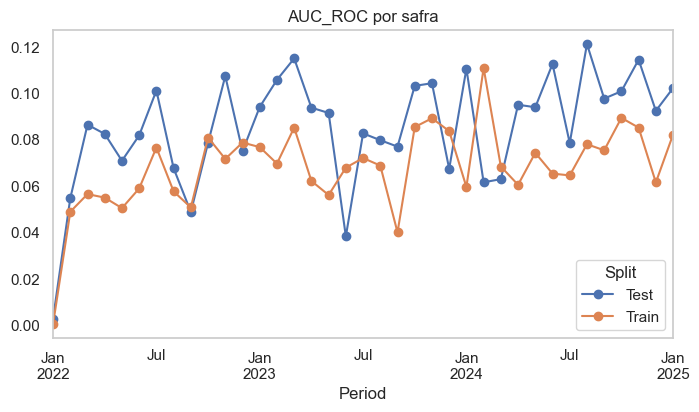

In [29]:
# Ex.: plotar MCC ao longo do tempo
(
    metrics_by_vintage["AUC_ROC"]
    .unstack(level="Split")
    .plot(marker="o", figsize=(8,4), title="AUC_ROC por safra").grid(visible=False)
)

In [ ]:
evaluator.plot_confusion(
    splits=["train",'test']
    )

In [ ]:
evaluator.plot_calibration(
    splits=["train",'test']
    )

In [ ]:
# hover text nao foi melhorado

#evaluator.plot_event_rate()

In [ ]:
# falta aplicar a separação por graficos com parametro features
# feature='acc_open_past_24_mths'

#evaluator.plot_psi()

In [ ]:
evaluator.plot_ks()

In [ ]:
evaluator.plot_group_radar()

In [ ]:
evaluator.plot_decile_ks()

### Teste de Stress

In [ ]:
gen = LookAhead(id_cols=['id'], date_cols=['date']).fit(train)
evaluator.synthetic_gen = gen
stress = evaluator.run_stress_test()
stress['metrics']